---
title: Data Exploration
format:
    html:
        embed-resources: true
---

# Exploratory Data Analysis

In order to do machine learning with our data, we need to develop a thorough understanding of the data and the relationships between the variables. We will do Exploratory Data Analysis (EDA) to understand the data and to prepare for modeling.

## Text Data

To begin, we can explore the textual data gathered that relates to psychosis and cannabis. This text data will be essential for answering questions regarding public sentiment related to the impact of cannabis on psychosis and/or schizophrenia.

### Reddit



In [3]:
library(tidyverse, quietly = TRUE, warn.conflicts = FALSE)

wiki_data <- read_delim(
        "../data/clean_data/wiki_clean_data.txt",
        delim = "\n",
        col_names = FALSE
    )

wiki_labels <- read_delim(
        "../data/clean_data/wiki_clean_data_labels.txt",
        delim = "\n",
        col_names = FALSE
    )

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.3     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.4     v tibble    3.2.1
v lubridate 1.9.3     v tidyr     1.3.0
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 157213 Columns: 1
-- Column specification --------------------------------------------------------
Delimiter: "\001"
chr (1): X1

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1192 Columns: 1
-- Column specification --------------------------------------------------------
Delimiter: "\001"
chr (1): X1

i Use `spec()` to retrieve the full column specifica

In [7]:
reddit_data <- read_csv(
        "../data/clean_data/reddit_cleaned_text.csv"
    )

Rows: 30000 Columns: 2
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (2): label, text

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
library(ggwordcloud)
library(tidytext)
library(wordcloud)

In [50]:
tidy_wiki <- wiki_data %>%
    mutate(id = row_number()) %>%
    unnest_tokens(word, X1) %>%
    count(id, word) %>%
    group_by(word) %>%
    mutate(word_count = sum(n)) %>%
    ungroup()

In [52]:
tidy_wiki <- tidy_wiki %>%
  anti_join(stop_words) %>%
  filter(word != "numbr")

Joining with `by = join_by(word)`


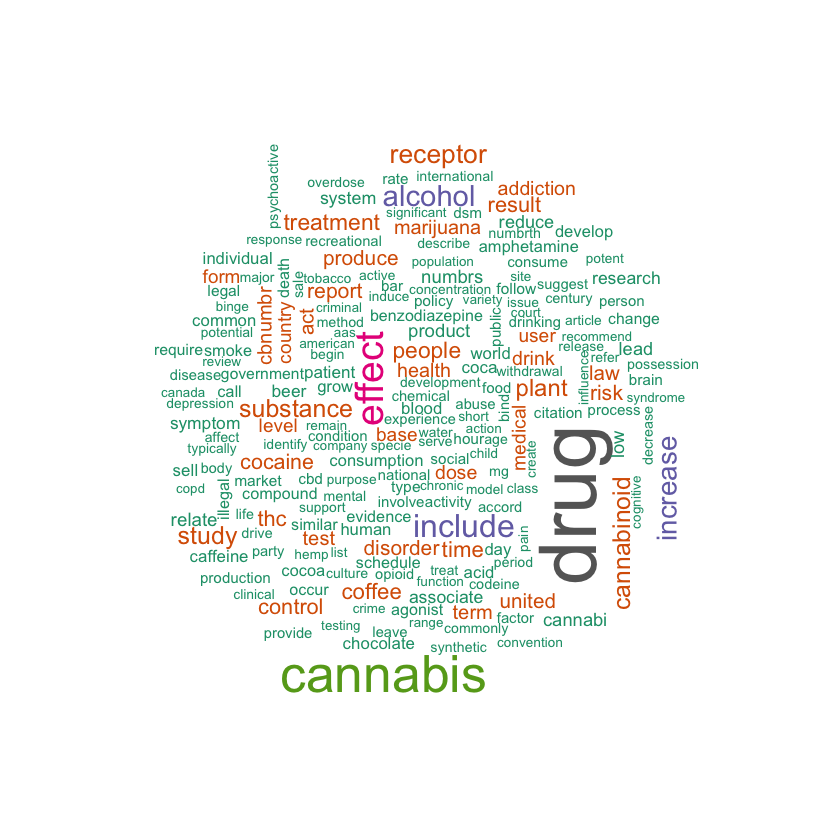

In [63]:
library(wordcloud)

tidy_wiki %>%
    select(word, word_count) %>%
    distinct() %>%
    with(wordcloud(word, word_count, max.words = 200, colors = brewer.pal(8, "Dark2")))

In [9]:
tidy_reddit <- reddit_data %>%
    distinct() %>%
    filter(!is.na(text)) %>%
    unnest_tokens(word, text) %>%
    group_by(label, word) %>%
    summarise(n = n()) %>%
    ungroup() %>%
    group_by(word) %>%
    mutate(word_count = sum(n)) %>%
    ungroup() %>%
    arrange(-word_count)

`summarise()` has grouped output by 'label'. You can override using the
`.groups` argument.


In [10]:
tidy_reddit <- tidy_reddit %>%
  anti_join(stop_words) %>%
  filter(word != "numbr")

Joining with `by = join_by(word)`


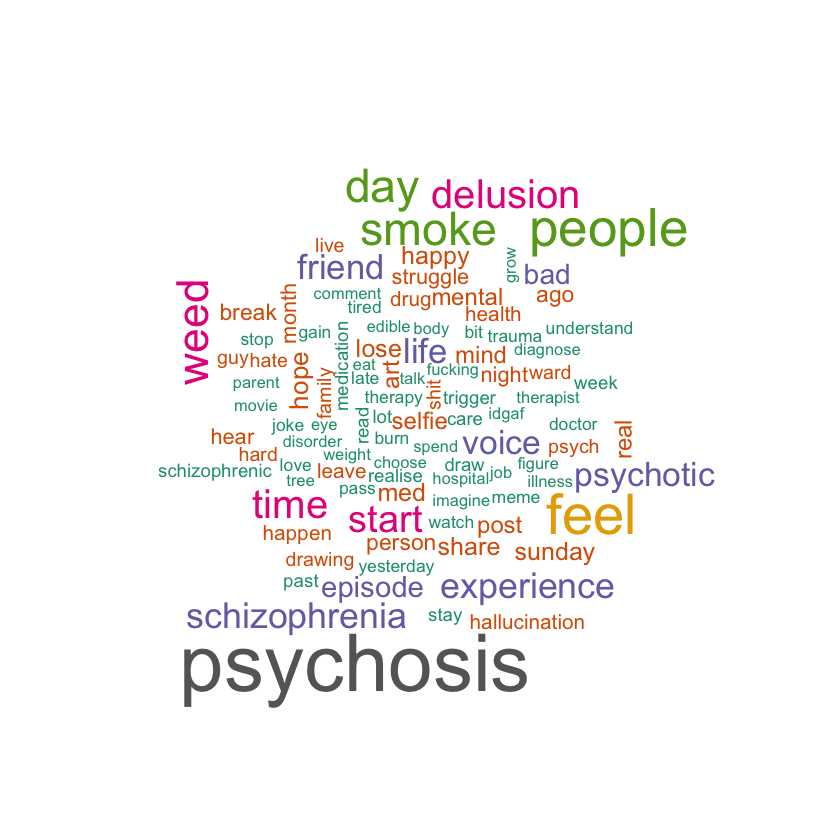

In [11]:
tidy_reddit %>%
    select(word, word_count) %>%
    distinct() %>%
    with(wordcloud(word, word_count, max.words = 100, colors = brewer.pal(8, "Dark2")))

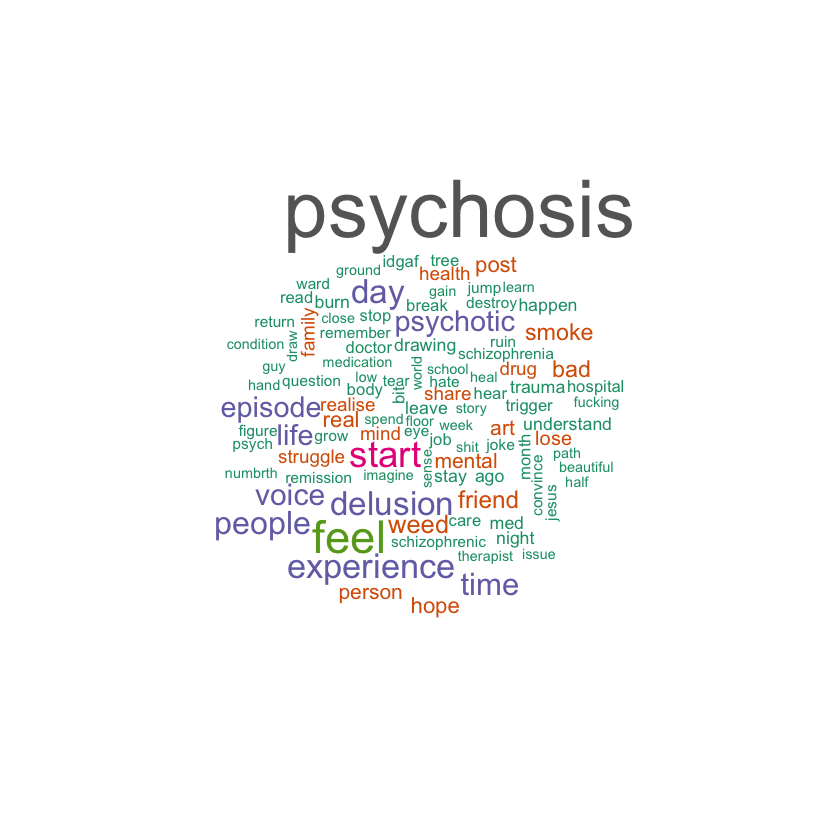

In [12]:
tidy_reddit %>%
    filter(label == "Psychosis") %>%
    select(word, n) %>%
    distinct() %>%
    with(wordcloud(word, n, max.words = 100, colors = brewer.pal(8, "Dark2"), min.freq = 2))

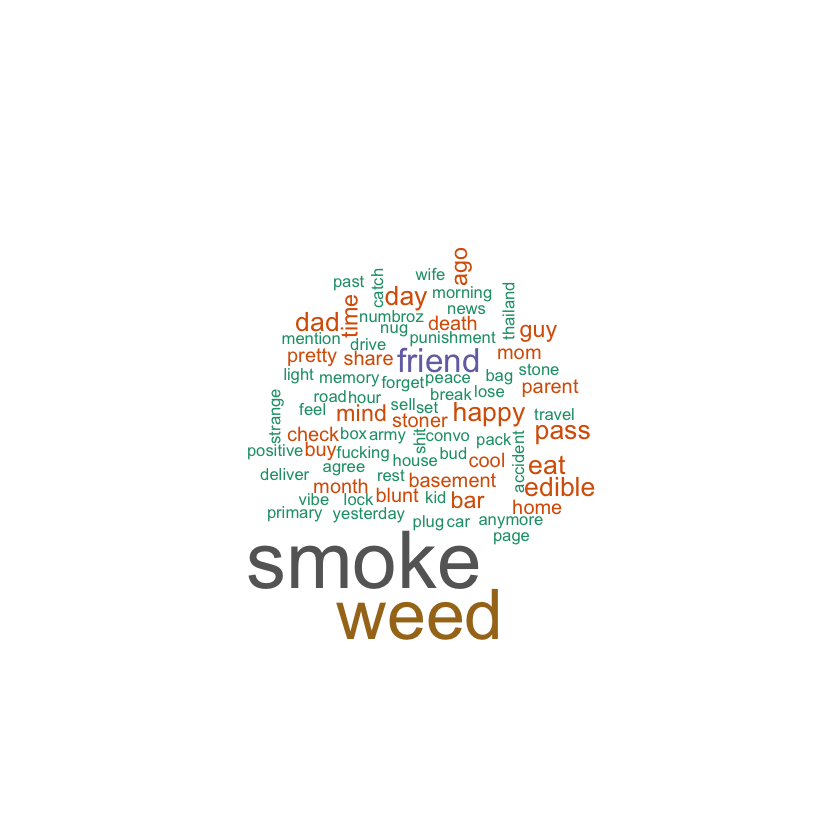

In [13]:
tidy_reddit %>% 
    filter(label == "weed") %>%
    select(word, n) %>%
    distinct() %>%
    with(wordcloud(word, n, max.words = 100, colors = brewer.pal(8, "Dark2"), min.freq = 2))

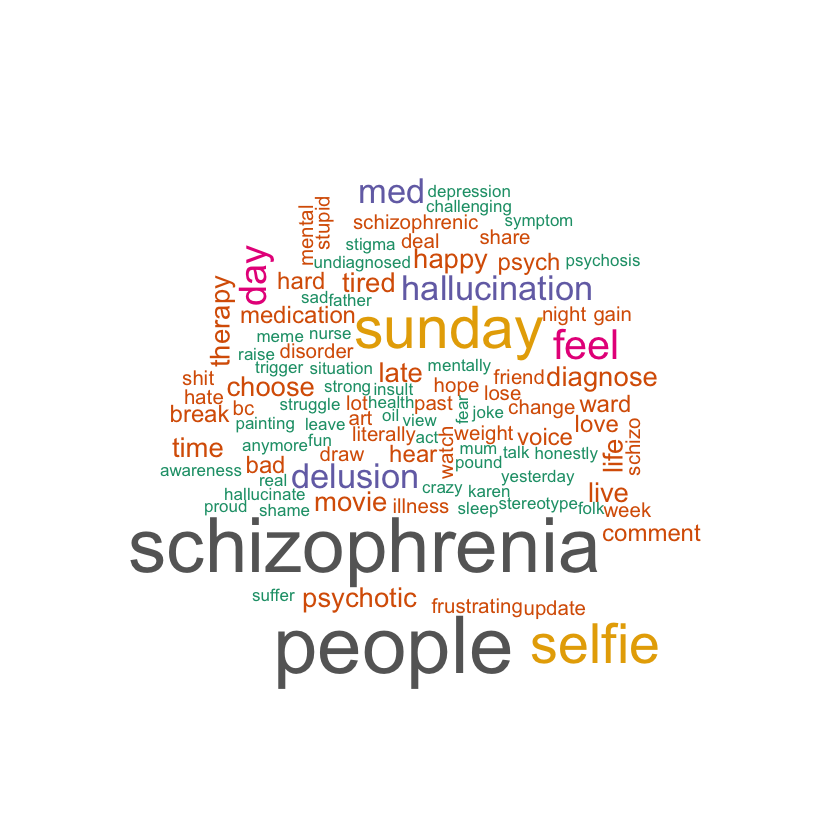

In [14]:
tidy_reddit %>%
    filter(label == "schizophrenia") %>%
    select(word, n) %>%
    distinct() %>%
    with(wordcloud(word, n, max.words = 100, colors = brewer.pal(8, "Dark2"), min.freq = 2))

Warning message in wordcloud_boxes(data_points = points_valid_first, boxes = boxes, :
"Some words could not fit on page. They have been removed."


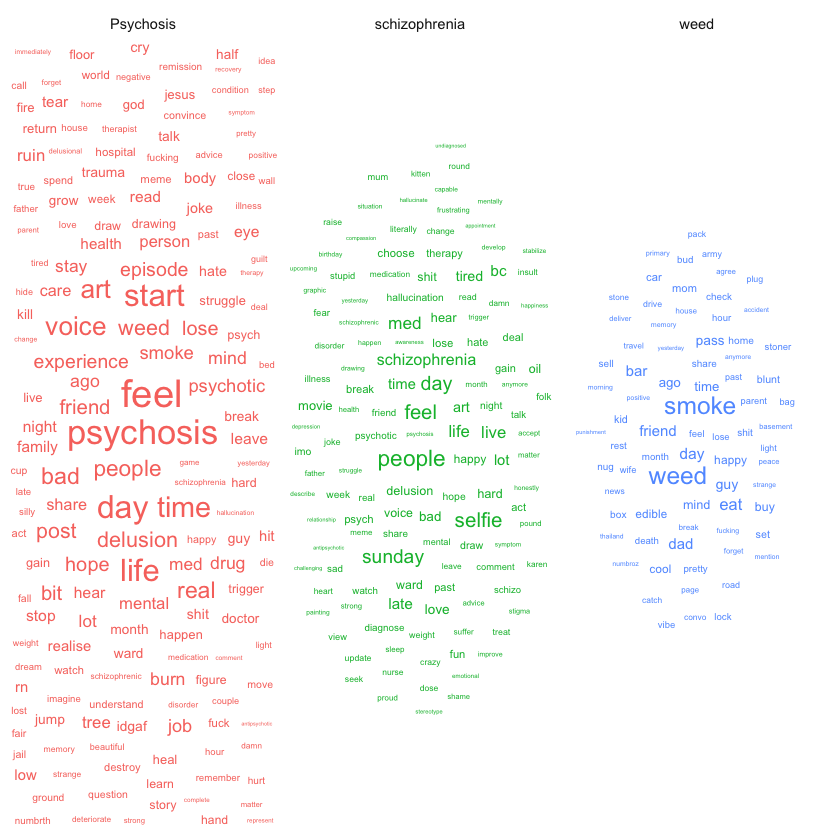

In [21]:
ggplot(
  tidy_reddit %>% filter(stringi::stri_enc_isascii(word)) %>% filter(n >= 2),
  aes(
    label = word, size = n, color = label
  )
) +
  geom_text_wordcloud_area(rm_outside = TRUE) +
  scale_size_area(max_size = 20) +
  theme_minimal() +
  facet_wrap(~label)

In [26]:
tidy_reddit %>%
    mutate(nchar = nchar(word)) %>%
    group_by(label) %>%
    summarize(mean = mean(nchar))

label,mean
<chr>,<dbl>
Psychosis,6.411458
schizophrenia,6.291242
weed,5.555046


In [30]:
reddit_data %>%
    distinct() %>%
    filter(!is.na(text)) %>%
    mutate(sentence_length = stringr::str_count(text, "\\S+")) %>%
    group_by(label) %>%
    summarize(mean = mean(sentence_length))

label,mean
<chr>,<dbl>
Psychosis,26.979381
schizophrenia,10.802083
weed,8.262626


In [32]:
tidy_reddit %>%
    group_by(label) %>%
    summarise(n = n())

label,n
<chr>,<int>
Psychosis,960
schizophrenia,491
weed,436


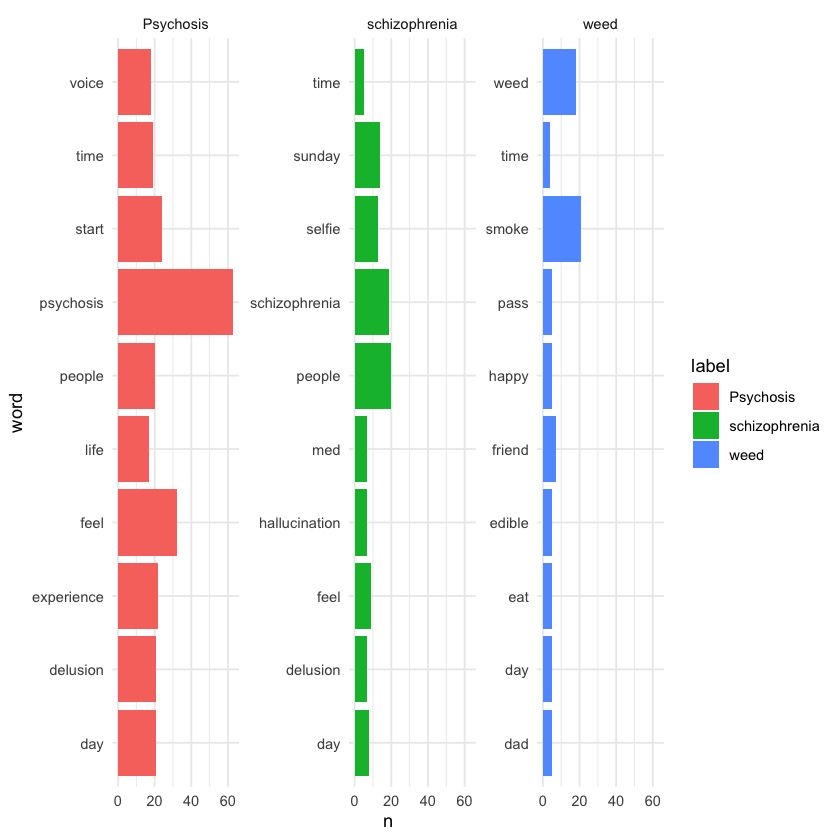

In [42]:
tidy_reddit %>%
    filter(stringi::stri_enc_isascii(word)) %>%
    group_by(label) %>%
    arrange(-n) %>%
    slice_head(n = 10) %>%
    ggplot(aes(x = n, y = word, fill = label)) +
    geom_bar(stat = "identity") +
    theme_minimal() +
    facet_wrap(~label, scales = "free_y")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


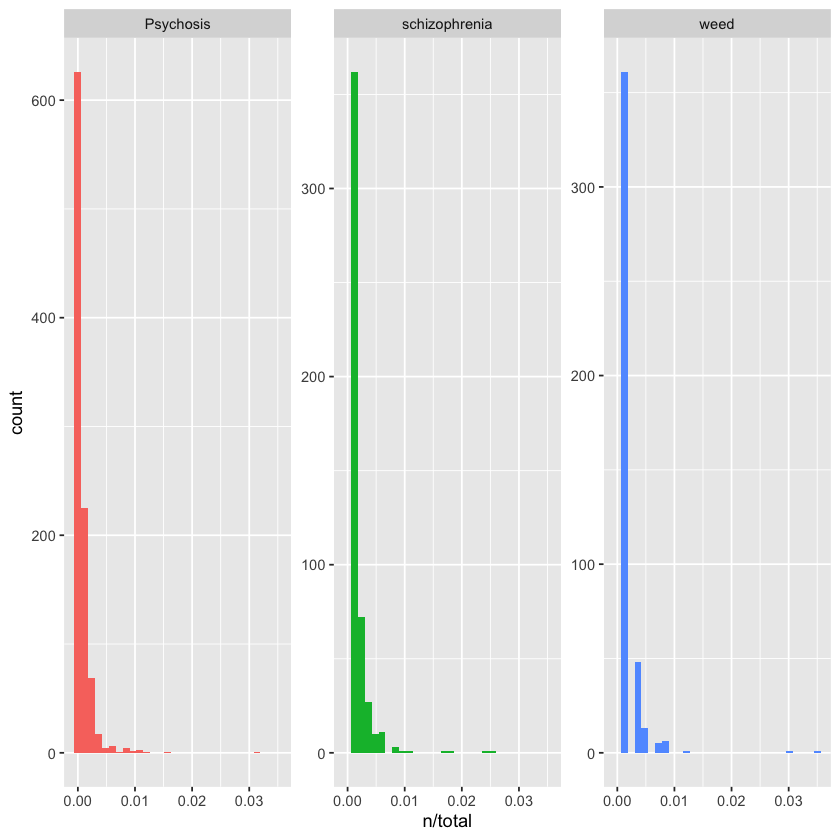

In [53]:
tidy_reddit %>%
    group_by(label) %>%
    mutate(total = sum(n)) %>%
    ggplot(aes(n/total, fill = label)) +
    geom_histogram(show.legend = FALSE) +
    facet_wrap(~label, ncol = 3, scales = "free_y")

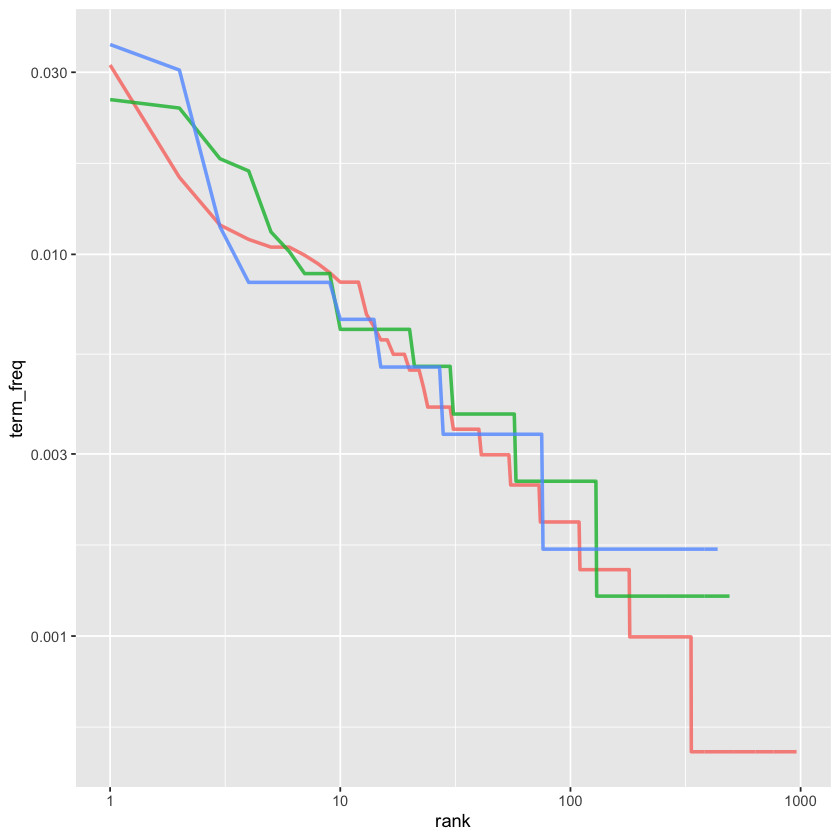

In [67]:
tidy_reddit %>%
  group_by(label) %>%
  mutate(total = sum(n)) %>%
  arrange(label, -n) %>%
  mutate(rank = row_number(), term_freq = n/total) %>%
  ungroup() %>%
  ggplot(aes(rank, term_freq, color = label)) + 
  geom_line(size = 1, alpha = 0.8, show.legend = FALSE) +
  scale_x_log10() +
  scale_y_log10()

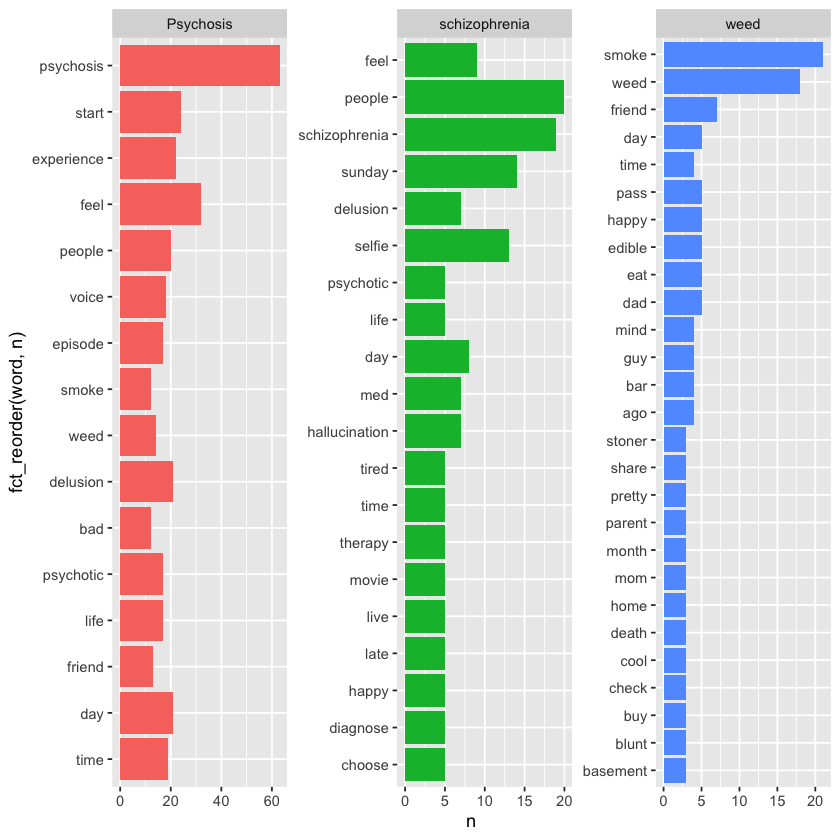

In [86]:
tidy_reddit %>%
  group_by(label) %>%
  slice_max(n, n = 15) %>%
  ungroup() %>%
  ggplot(aes(n, fct_reorder(word, n), fill = label)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~label, ncol = 3, scales = "free")